In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
TOPOLOGY = 'b4'  # choose the topology whose results you want to plot, either B4 or ATT

In [3]:
LABELS = ['Optimistic', 'Hedge-TE', 'Pessimistic', 'TeaVaR-90', 'TeaVaR-50', 'RADWAN']
color_mapping = {
    'Optimistic': 'goldenrod',
    'Pessimistic': 'darkviolet',
    'Hedge-TE': 'dodgerblue',
    'TeaVaR-50': 'coral',
    'TeaVaR-90': 'mediumseagreen', 
    'RADWAN': 'slategrey'
}

method_to_label_map = {
    'naive_optimistic': 'Optimistic',
    'naive_pessimistic': 'Pessimistic',
    'hedge': 'Hedge-TE',
    'teavar50': 'TeaVaR-50',
    'teavar90': 'TeaVaR-90',
    'radwan': 'RADWAN'
}

label_to_marker_map = {
    'Optimistic': 'o',
    'Pessimistic': 'v',
    'Hedge-TE': '|',
    'TeaVaR-50': 's',
    'TeaVaR-90': 'x',
    'RADWAN': 'p'
}

In [4]:
if TOPOLOGY == 'b4':
    methods = ['naive_optimistic', 'naive_pessimistic', 'teavar50', 'teavar90', 'radwan', 'hedge']
elif TOPOLOGY == 'att':
    methods = ['naive_optimistic', 'naive_pessimistic', 'teavar50', 'radwan', 'hedge']
elif TOPOLOGY == 'cloudwan':
    methods = ['naive_optimistic', 'naive_pessimistic', 'radwan', 'hedge']
else:
    raise ValueError("Invalid topology")

combined_results = {}

for i in range(10):
    # if you want to plot results from your own experiments, replace the file name below
    with open(f"../data/results/{TOPOLOGY}/experiment_v{i}.pkl", 'rb') as fp:
        curr_results = pickle.load(fp)
    for demand_scale, data in curr_results.items():
        if demand_scale not in combined_results:
            combined_results[demand_scale] = {}
        for analysis, vals in data.items():
            if analysis not in combined_results[demand_scale]:
                combined_results[demand_scale][analysis] = []
            if type(vals) == list:
                combined_results[demand_scale][analysis].extend(vals)
            else:
                combined_results[demand_scale][analysis].append(vals)
            
combined_results = dict(sorted(combined_results.items()))

In [5]:
demand_scales = []
aggregated_results = {}

for method in methods:
    aggregated_results[method] = {
        'pct_change_throughputs': [],
        'p95_overflows': [],
        'recomputations': []
    }

for demand_scale, results in combined_results.items():
    demand_scales.append(demand_scale)

    for method in methods:
        aggregated_results[method]['pct_change_throughputs'].append(
            np.mean([100 * (x - y)/y for x, y in zip(results[method + "_throughput"], results["naive_pessimistic_throughput"])])
        )
        aggregated_results[method]['p95_overflows'].append(np.percentile(results[method + '_reductions'], 95) / 1000)
        aggregated_results[method]['recomputations'].append(100 * (1 - (np.mean(results[method + '_runs'])/1000)))

/var/folders/4y/0rnql80j71gdg0q18j_861nw0000gp/T/ipykernel_63144/3664784011.py:31: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([v for v in lines.values()], labels=[k for k in lines.keys()], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(methods), fontsize=24, frameon=False)


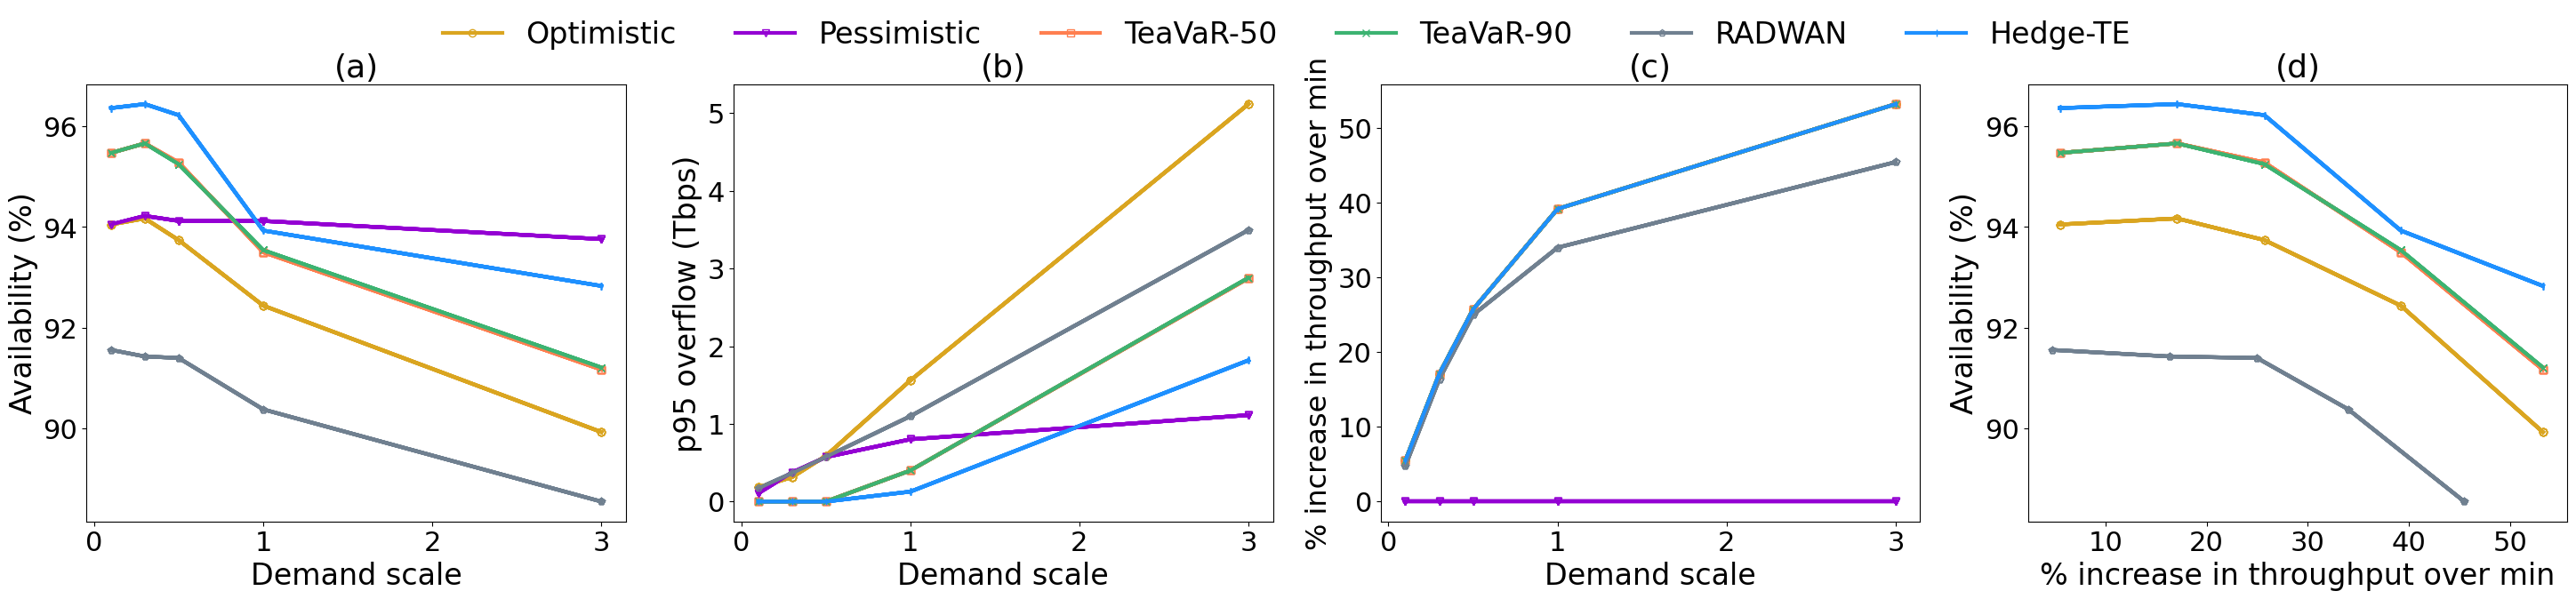

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(36, 6))
plt.rcParams.update({'font.size': 22})

lines = {}

for method in methods:
    for method in methods:
        label = method_to_label_map[method]
        lines[label] = axes[0].plot(demand_scales, aggregated_results[method]['recomputations'], color=color_mapping[label], marker=label_to_marker_map[label],  markerfacecolor='none', lw=3, label=label)
        axes[1].plot(demand_scales, aggregated_results[method]['p95_overflows'], color=color_mapping[label],  marker=label_to_marker_map[label],  markerfacecolor='none', lw=3, label=label)
        axes[2].plot(demand_scales, aggregated_results[method]['pct_change_throughputs'], color=color_mapping[label],  marker=label_to_marker_map[label],  markerfacecolor='none', lw=3, label=label)
        if method != 'naive_pessimistic':
            axes[3].plot(aggregated_results[method]['pct_change_throughputs'], aggregated_results[method]['recomputations'], marker=label_to_marker_map[label],  markerfacecolor='none', lw=3, color=color_mapping[label], label=label)

axes[0].set_xlabel("Demand scale", fontsize=24)
axes[0].set_ylabel("Availability (%)", fontsize=24)
axes[0].set_title("(a)", fontsize=26)

axes[1].set_xlabel("Demand scale", fontsize=24)
axes[1].set_ylabel("p95 overflow (Tbps)", fontsize=24)
axes[1].set_title("(b)", fontsize=26)

axes[2].set_xlabel("Demand scale", fontsize=24)
axes[2].set_ylabel("% increase in throughput over min", fontsize=23)
axes[2].set_title("(c)", fontsize=26)

axes[3].set_xlabel("% increase in throughput over min", fontsize=24)
axes[3].set_ylabel("Availability (%)", fontsize=24)
axes[3].set_title("(d)", fontsize=26)

fig.legend([v for v in lines.values()], labels=[k for k in lines.keys()], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(methods), fontsize=24, frameon=False)
fig.subplots_adjust(top=0.93)
plt.show()